#### imports
import keras text processing library to transform text (sentence) to sequence  
ref : [Creating sequence vector from text in Python](https://stackoverflow.com/questions/38302280/creating-sequence-vector-from-text-in-python)

In [1]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

Using TensorFlow backend.


In [2]:
# pre process the input data : alice.en
with open('./data/alice.en') as f:
    input_lines = f.read().splitlines()
print('no. of lines {}'.format(len(input_lines)))
# tokenizer which makes the text lower case and split by space
en_tokenizer = Tokenizer(lower=True, split=" ", filters='')
en_tokenizer.fit_on_texts(input_lines)

# get sequences
input_seqs = en_tokenizer.texts_to_sequences(input_lines)
print('sample seq:')
for i, (line, seq) in enumerate(zip(input_lines[:5], input_seqs[:5])):
    print('  line {}:'.format(i + 1))
    print('    text  > {}'.format(line))
    print('    seq   > {}'.format(seq))


no. of lines 2791
sample seq:
  line 1:
    text  > project gutenberg’s alice’s adventures in wonderland , by lewis carroll
    seq   > [56, 1318, 262, 355, 13, 493, 1, 67, 829, 830]
  line 2:
    text  > this ebook is for the use of anyone anywhere at no cost and with
    seq   > [30, 494, 39, 32, 2, 164, 8, 716, 1016, 24, 57, 831, 5, 23]
  line 3:
    text  > almost no restrictions whatsoever . you may copy it , give it away or
    seq   > [495, 57, 1319, 1320, 3, 14, 188, 356, 10, 1, 326, 10, 182, 35]
  line 4:
    text  > re - use it under the terms of the project gutenberg license included
    seq   > [1321, 25, 164, 10, 217, 2, 218, 8, 2, 56, 52, 286, 1017]
  line 5:
    text  > with this ebook or online at www . gutenberg . org
    seq   > [23, 30, 494, 35, 832, 24, 1018, 3, 52, 3, 456]


In [3]:
# vocabulary size
len(en_tokenizer.word_index)

3374

In [4]:
# pre process the output data : alice.x
with open('./data/alice.x') as f:
    output_lines = f.read().splitlines()
print(len(output_lines))
# tokenizer which makes the text lower case and split by space
x_tokenizer = Tokenizer(lower=True, split=" ", filters='')
x_tokenizer.fit_on_texts(output_lines)

# get sequences:
output_seqs = x_tokenizer.texts_to_sequences(output_lines)
print('sample seq:')
for i, (line, seq) in enumerate(zip(output_lines[:5], output_seqs[:5])):
    print('  line {}:'.format(i + 1))
    print('    text  > {}'.format(line))
    print('    seq   > {}'.format(seq))


2791
sample seq:
  line 1:
    text  > scw%57x ’6x5?e5c’”u 4-f75”u 4t/5?x6c5u f? rw?t5c-4?t $ e[ -5rfu 74ccw--
    seq   > [56, 1318, 262, 355, 13, 493, 1, 67, 829, 830]
  line 2:
    text  > x]fu 5eww! fu ;wc x]5 6u5 w; 4?[w?5 4?[r]5c5 4x ?w 7wux 4?t rfx]
    seq   > [30, 494, 39, 32, 2, 164, 8, 716, 1016, 24, 57, 831, 5, 23]
  line 3:
    text  > 4-:wux ?w c5uxcf7xfw?u r]4xuw5/5c q [w6 :4[ 7ws[ fx $ ’f/5 fx 4r4[ wc
    seq   > [495, 57, 1319, 1320, 3, 14, 188, 356, 10, 1, 326, 10, 182, 35]
  line 4:
    text  > c5 1 6u5 fx 6?t5c x]5 x5c:u w; x]5 scw%57x ’6x5?e5c’ -f75?u5 f?7-6t5t
    seq   > [1321, 25, 164, 10, 217, 2, 218, 8, 2, 56, 52, 286, 1017]
  line 5:
    text  > rfx] x]fu 5eww! wc w?-f?5 4x rrr q ’6x5?e5c’ q wc’
    seq   > [23, 30, 494, 35, 832, 24, 1018, 3, 52, 3, 456]


In [5]:
import numpy as np
import tensorflow as tf
# use helper method from for padding : https://github.com/ematvey/tensorflow-seq2seq-tutorials
import helpers

#start setup of tf network graph
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [6]:
tf.__version__

'1.2.0'

In [7]:
PAD = 0
#EOS = 1 not using any end of sentence identifier

vocab_size = len(en_tokenizer.word_index) + 1
input_embedding_size = 20 # random value : need to study how to set correct value

encoder_hidden_units = 20 # random value
decoder_hidden_units = encoder_hidden_units

In [8]:
#define placeholder for encoder input, decoder targets and decoder inputs 
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')

In [9]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

In [10]:
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

In [11]:
# setup the encoder network - LSTM cell
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_inputs_embedded,
    dtype=tf.float32, time_major=True,
)

del encoder_outputs # only encoder final state is being used

In [12]:
# setup the decoder network - LSTM cell
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)

decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    decoder_cell, decoder_inputs_embedded,
    initial_state=encoder_final_state,
    dtype=tf.float32, time_major=True, scope="plain_decoder",
)


dynamic_rnn(
    cell,
    inputs,
    sequence_length=None,
    initial_state=None,
    dtype=None,
    parallel_iterations=None,
    swap_memory=False,
    time_major=False,
    scope=None
)

In [13]:
# setup logits layer
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)

decoder_prediction = tf.argmax(decoder_logits, 2)

In [14]:
# setup loss function 
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)


In [15]:
# initialize gloabal variables
sess.run(tf.global_variables_initializer())

In [16]:
# method to get individual batch data
def next_feed(batch_seq, input_seqs, output_seqs):
    start = batch_seq*10
    end = (batch_seq+1)*10
    batch_ = input_seqs[start:end]
    dbatch_ = output_seqs[start:end]
    encoder_inputs_, _ = helpers.batch(batch_)
    decoder_targets_, _ = helpers.batch(dbatch_)
    decoder_inputs_, _ = helpers.batch(dbatch_)
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

In [17]:
loss_track = []
batch_size = 10
max_batches = 200
batches_in_epoch = 199
num_epoch = 50 # tried many no. of epoch 10 - 50 and after 50 seems to give very less error

try:
    for epoch in range(num_epoch):
        print('==> epoch {}:'.format(epoch + 1))
        for batch in range(max_batches):
            #print(input_seqs)
            fd = next_feed(batch, input_seqs, output_seqs)
            _, l = sess.run([train_op, loss], fd)
            loss_track.append(l)

            if batch == 0 or batch % batches_in_epoch == 0:
                print('batch {}'.format(batch))
                print('  minibatch loss: {}'.format(sess.run(loss, fd)))
                predict_ = sess.run(decoder_prediction, fd)
                for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                    print('  sample {}:'.format(i + 1))
                    print('    input     > {}'.format(inp))
                    print('    predicted > {}'.format(pred))
                    if i >= 2:
                        break
                print()
except KeyboardInterrupt:
    print('training interrupted')

==> epoch 1:
batch 0
  minibatch loss: 8.125134468078613
  sample 1:
    input     > [  56 1318  262  355   13  493    1   67  829  830    0    0    0    0]
    predicted > [3070  188  833  833  358 3267 1714 2322  571  571 3106  800  800  800]
  sample 2:
    input     > [  30  494   39   32    2  164    8  716 1016   24   57  831    5   23]
    predicted > [1018 1673 2464  371  567 2463 2463 3234  164  447  447 1280 2998 2998]
  sample 3:
    input     > [ 495   57 1319 1320    3   14  188  356   10    1  326   10  182   35]
    predicted > [ 548 1818 1540 1544 2427 2263  322 2260 2260 2325 2325 2325 1288 2623]

batch 199
  minibatch loss: 4.829812049865723
  sample 1:
    input     > [2850 2851   65   63  695   14   18    3    4    0    0    0    0    0    0
    0    0    0    0    0]
    predicted > [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  sample 2:
    input     > [ 231  606  146    2  554    1    4   11   15    1 1438 1734   59  329  535
    0    0    0    0    0]
    predicte

batch 199
  minibatch loss: 2.9429357051849365
  sample 1:
    input     > [2850 2851   65   63  695   14   18    3    4    0    0    0    0    0    0
    0    0    0    0    0]
    predicted > [6 2 5 2 5 6 8 3 4 0 0 0 0 0 0 0 0 0 0 0]
  sample 2:
    input     > [ 231  606  146    2  554    1    4   11   15    1 1438 1734   59  329  535
    0    0    0    0    0]
    predicted > [15  2  6  2 10  1  4 11 15  1 21  6  1  2  6  0  0  0  0  0]
  sample 3:
    input     > [ 26   2 620   1 964  63  11   6   2 982   1  73 383 147   1 255  21 187
   0   0]
    predicted > [ 7  2  2  1  2  2  2  6  2  6  1  2  6  1  1  8  1 10  0  0]

==> epoch 9:
batch 0
  minibatch loss: 3.7997188568115234
  sample 1:
    input     > [  56 1318  262  355   13  493    1   67  829  830    0    0    0    0]
    predicted > [18  2  5  6 13  6  1  4  5  1  0  0  0  0]
  sample 2:
    input     > [  30  494   39   32    2  164    8  716 1016   24   57  831    5   23]
    predicted > [ 2 10  2  1  2  6  8  6  2  6 

batch 199
  minibatch loss: 1.8297041654586792
  sample 1:
    input     > [2850 2851   65   63  695   14   18    3    4    0    0    0    0    0    0
    0    0    0    0    0]
    predicted > [119  16  65  63  46  14  18   3   4   0   0   0   0   0   0   0   0   0
   0   0]
  sample 2:
    input     > [ 231  606  146    2  554    1    4   11   15    1 1438 1734   59  329  535
    0    0    0    0    0]
    predicted > [38  2 55  2 10  1  4 11 15  1 26 71 59 18 53  0  0  0  0  0]
  sample 3:
    input     > [ 26   2 620   1 964  63  11   6   2 982   1  73 383 147   1 255  21 187
   0   0]
    predicted > [26  2 13  1 13 63 11  6  2 19  1 73 28  1  1 31 21 59  0  0]

==> epoch 16:
batch 0
  minibatch loss: 2.994266986846924
  sample 1:
    input     > [  56 1318  262  355   13  493    1   67  829  830    0    0    0    0]
    predicted > [59  2 24 39 13 49  1 67 64 47  0  0  0  0]
  sample 2:
    input     > [  30  494   39   32    2  164    8  716 1016   24   57  831    5   23]
    pr

batch 199
  minibatch loss: 1.1788928508758545
  sample 1:
    input     > [2850 2851   65   63  695   14   18    3    4    0    0    0    0    0    0
    0    0    0    0    0]
    predicted > [124  16  65  63 221  14  18   3   4   0   0   0   0   0   0   0   0   0
   0   0]
  sample 2:
    input     > [ 231  606  146    2  554    1    4   11   15    1 1438 1734   59  329  535
    0    0    0    0    0]
    predicted > [231   2 146   2  10   1   4  11  15   1  96  50  59  15  57   0   0   0
   0   0]
  sample 3:
    input     > [ 26   2 620   1 964  63  11   6   2 982   1  73 383 147   1 255  21 187
   0   0]
    predicted > [ 26   2  39   1  13  63  11   6   2 124   1  73  28 147   1 255  21  59
   0   0]

==> epoch 23:
batch 0
  minibatch loss: 2.476639986038208
  sample 1:
    input     > [  56 1318  262  355   13  493    1   67  829  830    0    0    0    0]
    predicted > [108   2  24  39  13  13   1  67 236  72   0   0   0   0]
  sample 2:
    input     > [  30  494   39   32  

batch 199
  minibatch loss: 0.7646867632865906
  sample 1:
    input     > [2850 2851   65   63  695   14   18    3    4    0    0    0    0    0    0
    0    0    0    0    0]
    predicted > [116   2  65  63 130  14  18   3   4   0   0   0   0   0   0   0   0   0
   0   0]
  sample 2:
    input     > [ 231  606  146    2  554    1    4   11   15    1 1438 1734   59  329  535
    0    0    0    0    0]
    predicted > [231 606 146   2 554   1   4  11  15   1  96 197  59 329 535   0   0   0
   0   0]
  sample 3:
    input     > [ 26   2 620   1 964  63  11   6   2 982   1  73 383 147   1 255  21 187
   0   0]
    predicted > [ 26   2 143   1   8  63  11   6   2 102   1  73 383 147   1 255  21 187
   0   0]

==> epoch 30:
batch 0
  minibatch loss: 1.929907202720642
  sample 1:
    input     > [  56 1318  262  355   13  493    1   67  829  830    0    0    0    0]
    predicted > [108   0 262  39  13   6   1  67 236 594   0   0   0   0]
  sample 2:
    input     > [  30  494   39   32  

batch 199
  minibatch loss: 0.4710385203361511
  sample 1:
    input     > [2850 2851   65   63  695   14   18    3    4    0    0    0    0    0    0
    0    0    0    0    0]
    predicted > [329 663  65  63   5  14  18   3   4   0   0   0   0   0   0   0   0   0
   0   0]
  sample 2:
    input     > [ 231  606  146    2  554    1    4   11   15    1 1438 1734   59  329  535
    0    0    0    0    0]
    predicted > [231 606 146   2 554   1   4  11  15   1 296  14  59 329 535   0   0   0
   0   0]
  sample 3:
    input     > [ 26   2 620   1 964  63  11   6   2 982   1  73 383 147   1 255  21 187
   0   0]
    predicted > [ 26   2 143   1 550  63  11   6   2  15   1  73 383 147   1 255  21 187
   0   0]

==> epoch 37:
batch 0
  minibatch loss: 1.323203206062317
  sample 1:
    input     > [  56 1318  262  355   13  493    1   67  829  830    0    0    0    0]
    predicted > [480   0 262 355  13 493   1  67 236 594   0   0   0   0]
  sample 2:
    input     > [  30  494   39   32  

batch 199
  minibatch loss: 0.2686757743358612
  sample 1:
    input     > [2850 2851   65   63  695   14   18    3    4    0    0    0    0    0    0
    0    0    0    0    0]
    predicted > [367 663  65  63 695  14  18   3   4   0   0   0   0   0   0   0   0   0
   0   0]
  sample 2:
    input     > [ 231  606  146    2  554    1    4   11   15    1 1438 1734   59  329  535
    0    0    0    0    0]
    predicted > [ 231  606  146    2  554    1    4   11   15    1 1438  910   59  329  535
    0    0    0    0    0]
  sample 3:
    input     > [ 26   2 620   1 964  63  11   6   2 982   1  73 383 147   1 255  21 187
   0   0]
    predicted > [ 26   2 620   1 964  63  11   6   2 982   1  73 383 147   1 255  21 187
   0   0]

==> epoch 44:
batch 0
  minibatch loss: 0.7345508933067322
  sample 1:
    input     > [  56 1318  262  355   13  493    1   67  829  830    0    0    0    0]
    predicted > [  56 1318  262  355   13  493    1   67  829  830    0    0    0    0]
  sample 2:
   

batch 199
  minibatch loss: 0.15563812851905823
  sample 1:
    input     > [2850 2851   65   63  695   14   18    3    4    0    0    0    0    0    0
    0    0    0    0    0]
    predicted > [2095  663   65   63  695   14   18    3    4    0    0    0    0    0    0
    0    0    0    0    0]
  sample 2:
    input     > [ 231  606  146    2  554    1    4   11   15    1 1438 1734   59  329  535
    0    0    0    0    0]
    predicted > [ 231  606  146    2  554    1    4   11   15    1 1438 1734   59  329  535
    0    0    0    0    0]
  sample 3:
    input     > [ 26   2 620   1 964  63  11   6   2 982   1  73 383 147   1 255  21 187
   0   0]
    predicted > [ 26   2 620   1 964  63  11   6   2 982   1  73 383 147   1 255  21 187
   0   0]

==> epoch 50:
batch 0
  minibatch loss: 0.37500235438346863
  sample 1:
    input     > [  56 1318  262  355   13  493    1   67  829  830    0    0    0    0]
    predicted > [  56 1318  262  355   13  493    1   67  829  830    0    0    0

loss 0.1423 after 100000 examples (batch_size=10)


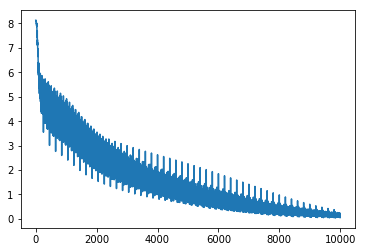

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))

In [20]:
# testing
fd = next_feed(max_batches, input_seqs, output_seqs)

print('  minibatch loss: {}'.format(sess.run(loss, fd)))
predict_ = sess.run(decoder_prediction, fd)
for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
    print('  sample {}:'.format(i + 1))
    print('    input     > {}'.format(inp))
    print('    predicted > {}'.format(pred))
    #if i >= 2:
    #    break
print()

  minibatch loss: 0.2442202866077423
  sample 1:
    input     > [ 41 443  46  17 108   1   4   2  96  92 180  13  87 440 140   3   5]
    predicted > [ 41 443  46  17 108   1   4   2  96  92 180  13  87 440 140   3   5]
  sample 2:
    input     > [   2  101  216  297    1 1078  288  109    8   77  355    3    4    0    0
    0    0]
    predicted > [   2  101  216  297    1 1078  288  109    8   77  355    3    4    0    0
    0    0]
  sample 3:
    input     > [ 41  65 179  14  95 355  20 287 112  30 753   1   4  11   0   0   0]
    predicted > [ 41  65 179  14  95 355  20 287 112  30 753   1   4  11   0   0   0]
  sample 4:
    input     > [  15    7   40  485   21  143  158   57  164  190  147    6 1075    1    0
    0    0]
    predicted > [  15    7   40  485   21  143  158   57  164  190  147    6 1075    1    0
    0    0]
  sample 5:
    input     > [335  17  16   7 438 516  64   3   4   0   0   0   0   0   0   0   0]
    predicted > [335  17  16   7 438 516  64   3   4   0 